### **Understanding the problem** ###


#### Target Output: `sii`

The `sii` column represents the Severity Impairment Index (SII), which is used to classify the severity of problematic internet use. It follows a scale defined as:

- **0**: None
- **1**: Mild
- **2**: Moderate
- **3**: Severe

Target `sii` is derived from the field `PCIAT-PCIAT_Total`.

#### Data Inputs:

- Internet usage behavior data
    - `Train.csv` (2736 ids has value in `sii`)
- Accelerometer time series data for single `id`, to be used as training data
    - `id.parquet` (available for  996 `id` in total)
    
Number of `id`(s) have both `sii` value and `id.parquet` file: 996

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
import seaborn as sns

### Data ingestion - load all csv files ###

In [4]:
# Load csv files into csv_file, within csv_file, each csv file is created as a df using the name of csv file.
csv_file = {}

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            key = filename.split('.')[0]
            csv_file[key] = pd.read_csv(os.path.join(dirname, filename))
            globals()[key] = csv_file[key] 

In [5]:
# Check train csv file
X = train
train.shape
#train[train['id'] == '5f099188']

(3960, 82)

### **Missing value in column `sii`** ###

In [6]:
X = train[train['sii'].notna()] # select rows where column sii is not null in train
id_sii_not_null = train[train['sii'].notna()]['id'].tolist() # get list of ids having non-null sii value.
print("Number of ids that has not null sii in train dataset: ", len(set(id_sii_not_null)))

Number of ids that has not null sii in train dataset:  2736


### **Create target set y** ###

In [7]:
y = X['sii']
y.head()

0    2.0
1    0.0
2    0.0
3    1.0
5    1.0
Name: sii, dtype: float64

### **EDA - Target value distribution** ###

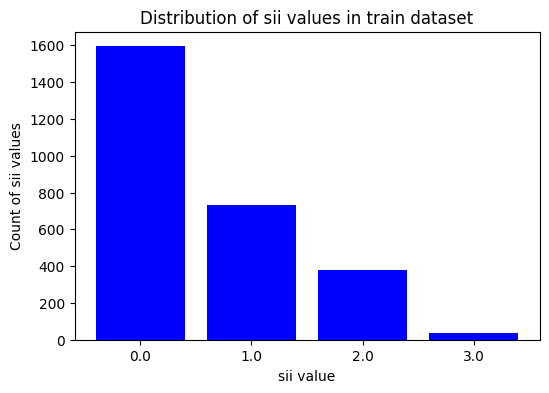

In [8]:
# count number of ids per sii value
sii_counts = X['sii'].value_counts()
# plot distritbuion of sii values
plt.figure(figsize = (6,4))
plt.bar(sii_counts.index, sii_counts.values, color = 'blue')
plt.xticks(ticks = sii_counts.index, labels = sii_counts.index)
plt.ylabel("Count of sii values")
plt.xlabel("sii value")
plt.title("Distribution of sii values in train dataset")
plt.show()

In [9]:
# get min and max PCIAT-PCIAT-Total score of sii values
result = X.groupby('sii')['PCIAT-PCIAT_Total'].agg([min, max]).reset_index()
result['count'] = sii_counts.values
result['count %'] = np.round(sii_counts.values / 2736,2)
result

/tmp/ipykernel_24/1605056357.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  result = X.groupby('sii')['PCIAT-PCIAT_Total'].agg([min, max]).reset_index()
/tmp/ipykernel_24/1605056357.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  result = X.groupby('sii')['PCIAT-PCIAT_Total'].agg([min, max]).reset_index()


,sii,min,max,count,count %
0,0.0,0.0,30.0,1594,0.58
1,1.0,31.0,49.0,730,0.27
2,2.0,50.0,79.0,378,0.14
3,3.0,80.0,93.0,34,0.01


### **Feature selection** ###

We know `PCIAT-PCIAT_Total` is a function of `PCIAT-PCIAT_XX`(s), which therefore can be dropped from the features.

In [10]:
# Drop "PCIAT-PCIAT_XX" columns and only keep the "PCIAT-PCIAT_Total" column
PCIAT_cols = [col for col in X.columns if col.startswith('PCIAT-PCIAT') ]
              #and col != 'PCIAT-PCIAT_Total']
X = X.drop(columns = PCIAT_cols)
X.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,NaN,Fall,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,NaN,Fall,2.340,Fall,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,Summer,2.170,Fall,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,NaN,Winter,2.451,Summer,Summer,31.0,45.0,Winter,0.0,1.0
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,NaN,Spring,4.110,Summer,Summer,40.0,56.0,Spring,0.0,1.0


In [12]:
# Check missing values
missing_values = X.isnull().sum()
missing_percent= round(X.isnull().mean() *100,1)
missing_percent_df = pd.DataFrame(
    {'feature': missing_percent.index,
     'missing_percent': missing_percent.values})
missing_percent_df = missing_percent_df.sort_values(by = 'missing_percent', ascending = True)

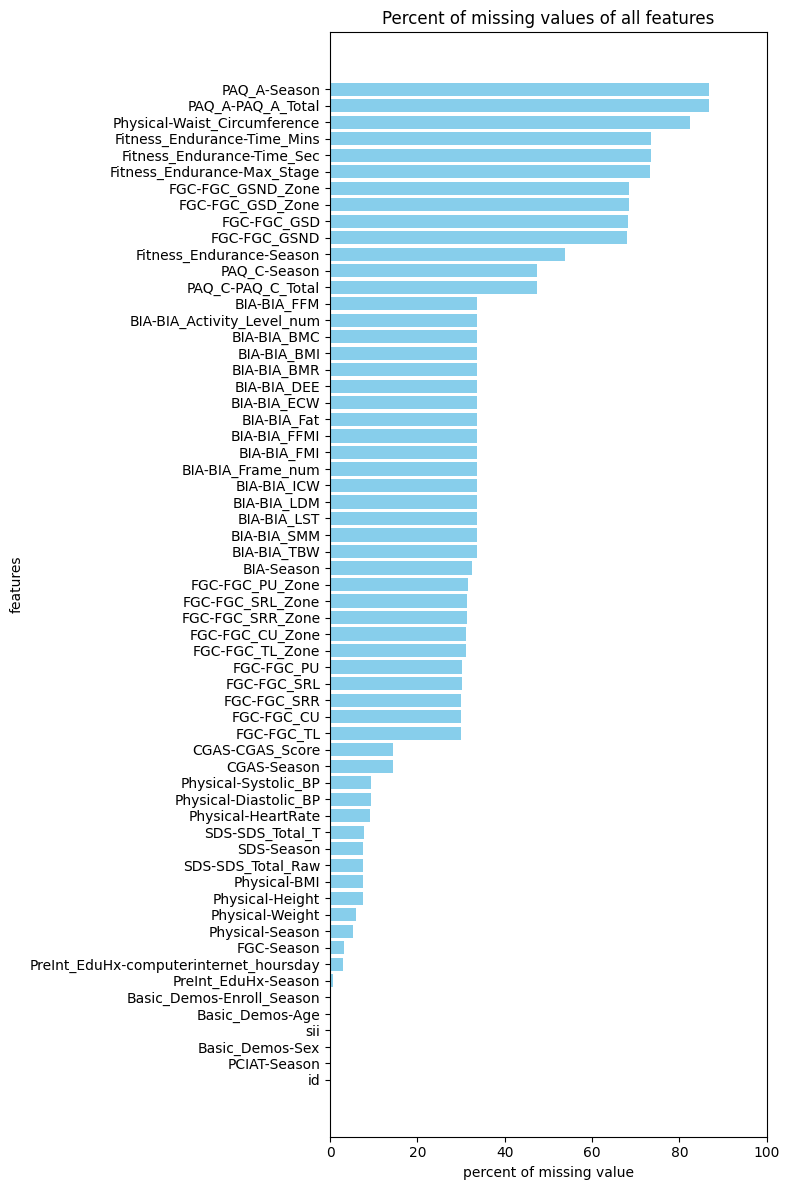

In [13]:
# Plot bar chart of missing values by features
plt.figure(figsize = (8,12)) # set figure size
plt.barh(missing_percent_df['feature'], missing_percent_df['missing_percent'],color = 'skyblue') # plot vertical bar chart
plt.xlabel("percent of missing value")
plt.ylabel("features")
plt.title("Percent of missing values of all features")
plt.xlim(0,100)
plt.tight_layout()
plt.show()

### **Replace missing value for categorical and numerical columns** ###

In [14]:
# address missing values in X_train
for col in X:
    if col in data_dictionary[data_dictionary['Type']=='categorical int']['Field'].unique().tolist():
        median_value = np.round(X[col].median(skipna=True),0)
        X[col] = X[col].fillna(median_value)
    elif col in data_dictionary[data_dictionary['Type']=='str']['Field'].unique().tolist():
        X[col] = X[col].fillna('missing value')
    elif col in data_dictionary[data_dictionary['Type'].isin(['float','int'])]['Field'].unique().tolist():
       median_value = X[col].median(skipna = True)
       X[col] = X[col].fillna(median_value)

### Drop columns having >=30% missing values ###

In [15]:
## setting missing value percent threshold  = 30%, drop features have >=30% missing values
missing_percent_df = missing_percent_df[missing_percent_df['missing_percent']>=30].sort_values(by='missing_percent',ascending = False).reset_index(drop = True)
missingvalue_cols = missing_percent_df['feature'].tolist()
X = X.drop(columns = missingvalue_cols)

In [16]:
X = X.drop(columns = ['sii','PCIAT-Season'])

In [17]:
X.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_TL,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,81.0,114.0,Fall,0.0,6.0,missing value,39.0,55.0,Fall,3.0
1,000fd460,Summer,9,0,missing value,65.0,Fall,14.035590,48.0,46.0,...,70.0,122.0,Fall,3.0,3.0,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,94.0,117.0,Fall,20.0,5.0,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,97.0,117.0,Summer,18.0,7.0,Summer,31.0,45.0,Winter,0.0
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,73.0,102.0,Summer,12.0,8.0,Summer,40.0,56.0,Spring,0.0


In [18]:
## check features left in X_train
train_col = X.columns.tolist()
len(train_col )

21

### **Feature preprocessing** ###

In [19]:
# Shuffle X_train, y_train
tf.random.set_seed(0)

X, y = shuffle(X, y, random_state = 42)

In [20]:
# Train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 1234, stratify = y)

In [21]:
cat_cols = [col for col in data_dictionary[data_dictionary['Type'].isin(['categorical int','str'])]['Field'].unique().tolist() if col in X_train.columns.tolist()]
non_cat_cols = [col for col in data_dictionary[~data_dictionary['Type'].isin(['categorical int','str'])]['Field'].unique().tolist() if col in X_train.columns.tolist()]

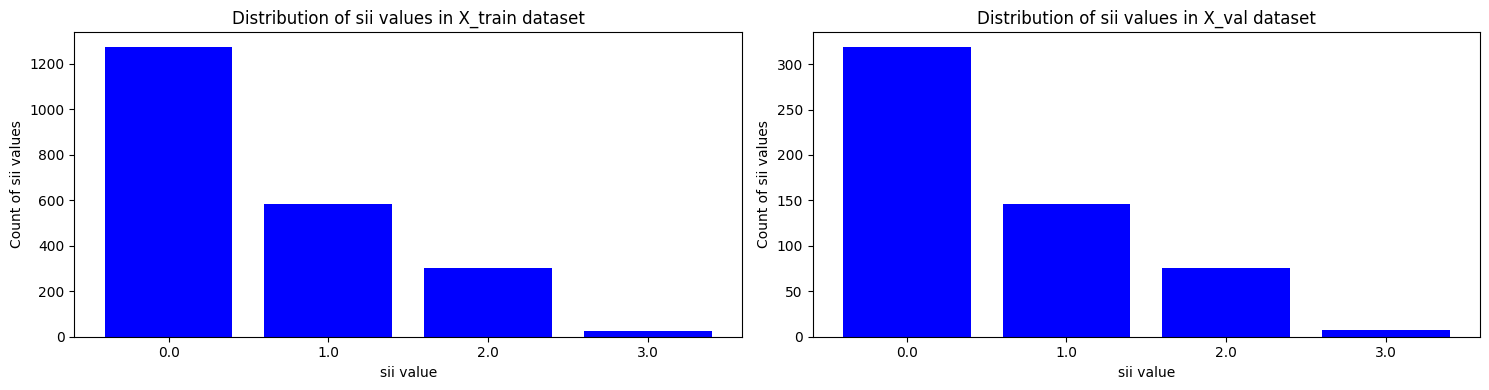

In [21]:
# count number of ids per sii value
train_dist = y_train.value_counts()
# plot distritbuion of sii values
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(train_dist.index, train_dist.values, color = 'blue')
plt.xticks(ticks = train_dist.index, labels = train_dist.index)
plt.ylabel("Count of sii values")
plt.xlabel("sii value")
plt.title("Distribution of sii values in X_train dataset")

# count number of ids per sii value
val_dist = y_val.value_counts()
# plot distritbuion of sii values
plt.subplot(1,2,2)
plt.bar(val_dist.index, val_dist.values, color = 'blue')
plt.xticks(ticks = val_dist.index, labels = val_dist.index)
plt.ylabel("Count of sii values")
plt.xlabel("sii value")
plt.title("Distribution of sii values in X_val dataset")
plt.tight_layout()

plt.show()

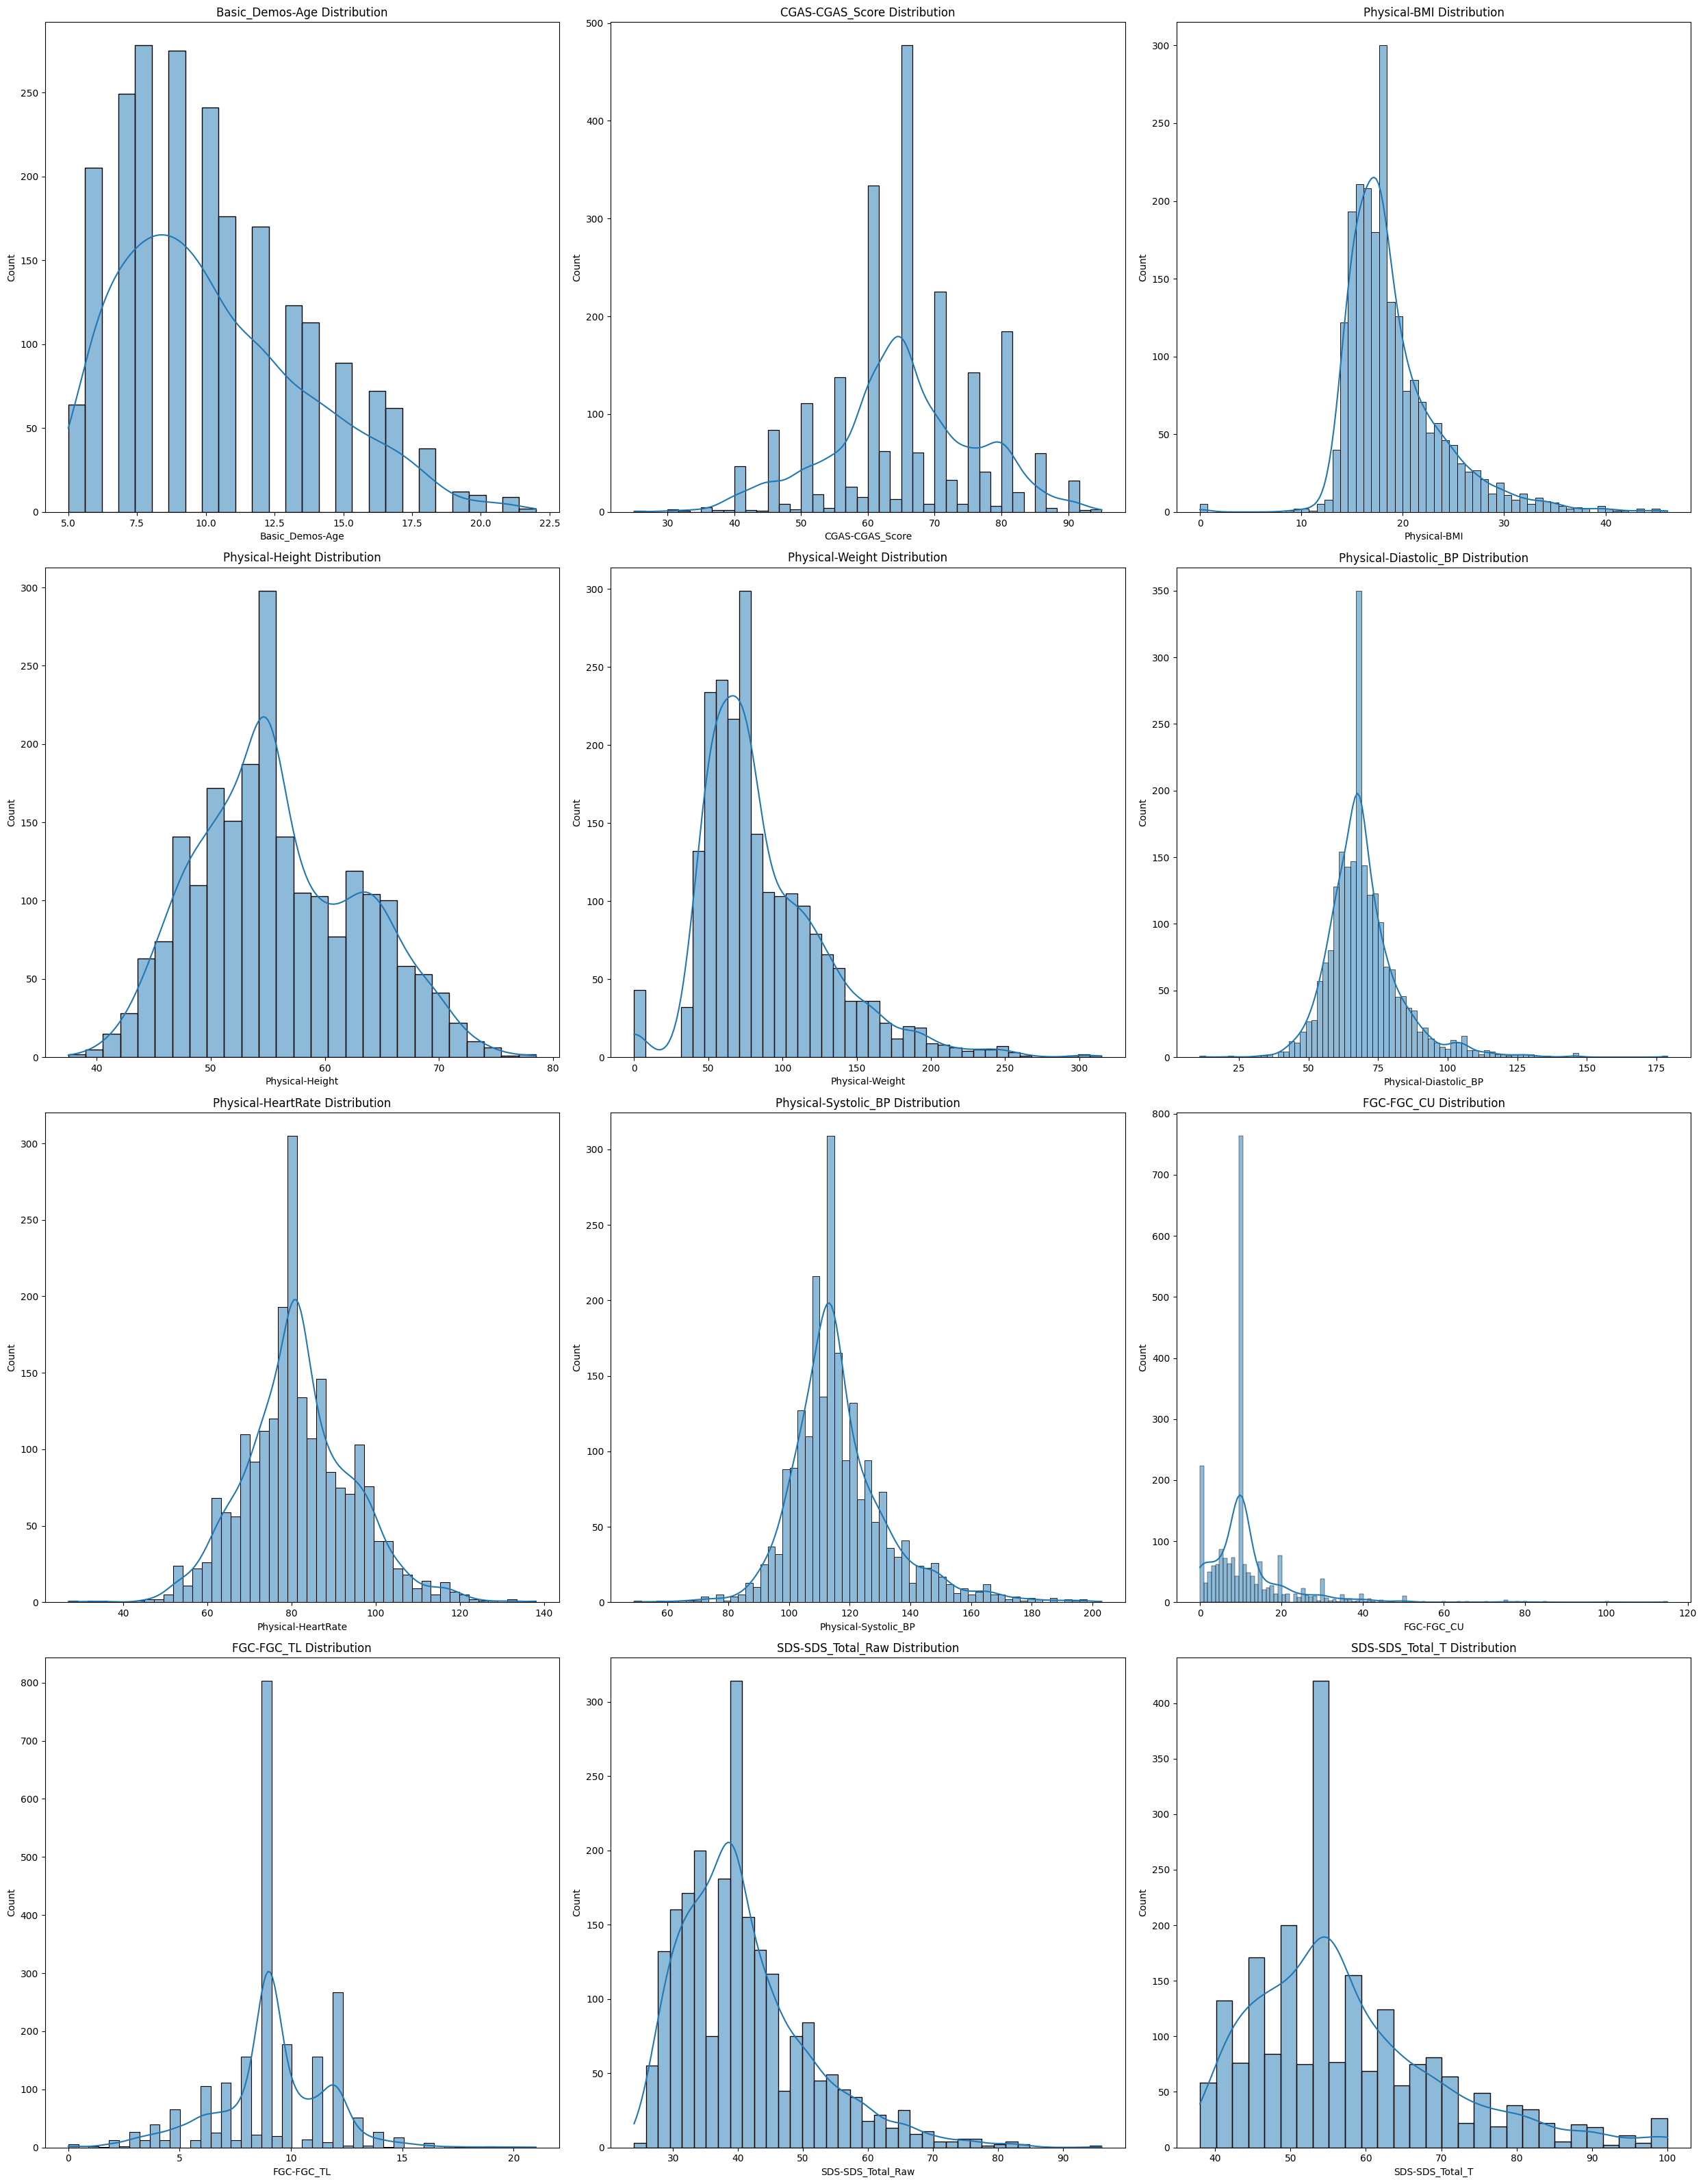

In [22]:

# Replace `inf` and `-inf` with `NaN` in the entire DataFrame
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
import warnings

warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

# Number of columns in the plot grid (3 per row)
num_columns = 3
# Calculate the number of rows needed to fit all plots
num_rows = (len(non_cat_cols) + num_columns - 1) // num_columns

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8 * num_rows))

# Flatten axes to make it easier to iterate over
axes = axes.flatten()

# Loop through each numerical column and plot the distribution
for i, col in enumerate(non_cat_cols):
    sns.histplot(X_train[col], kde=True, ax=axes[i])  # Plot histogram with KDE
    axes[i].set_title(f'{col} Distribution')          # Set title for each plot

# Hide any extra subplots if there are more axes than needed
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [23]:
#Standardization

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
#scaler = StandardScaler()
X_train[non_cat_cols] = scaler.fit_transform(X_train[non_cat_cols])
X_val[non_cat_cols] = scaler.transform(X_val[non_cat_cols])

In [24]:
# Categorical Features Handling

cat_cols.remove('id') # remove col id from categorical features
cat_cols_df_train = X_train[cat_cols] # prepare train set categorical cols as df for onehotencoding
cat_cols_df_val = X_val[cat_cols] # prepare val set categorical cols as df for onehotencoding
cat_cols_df_train.head() 

,Basic_Demos-Enroll_Season,Basic_Demos-Sex,CGAS-Season,Physical-Season,FGC-Season,SDS-Season,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
1059,Spring,1,Spring,Spring,Spring,Winter,Spring,0.0
2366,Spring,1,Summer,Spring,Summer,Summer,Spring,2.0
2821,Summer,0,Winter,Fall,Fall,Fall,Summer,2.0
2155,Fall,0,missing value,Fall,Fall,Fall,Fall,0.0
3278,Fall,0,Spring,Fall,Fall,Winter,Fall,2.0


In [25]:
# Features transformation - OneHotEncoder
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False) 
categorical_encoded_train = encoder.fit_transform (cat_cols_df_train) # onehotencoding transformation
column_names_train = encoder.get_feature_names_out(input_features=cat_cols_df_train.columns) # add headers for transformed cols
categorical_encoded_train_df = pd.DataFrame(categorical_encoded_train, columns =column_names_train, index = X_train.index) # convert to dataframe
categorical_encoded_train_df.head()

,Basic_Demos-Enroll_Season_Fall,Basic_Demos-Enroll_Season_Spring,Basic_Demos-Enroll_Season_Summer,Basic_Demos-Enroll_Season_Winter,Basic_Demos-Sex_0,Basic_Demos-Sex_1,CGAS-Season_Fall,CGAS-Season_Spring,CGAS-Season_Summer,CGAS-Season_Winter,...,SDS-Season_missing value,PreInt_EduHx-Season_Fall,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter,PreInt_EduHx-Season_missing value,PreInt_EduHx-computerinternet_hoursday_0.0,PreInt_EduHx-computerinternet_hoursday_1.0,PreInt_EduHx-computerinternet_hoursday_2.0,PreInt_EduHx-computerinternet_hoursday_3.0
1059,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2366,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2821,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2155,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3278,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [26]:
categorical_encoded_val = encoder.fit_transform (cat_cols_df_val) # onehotencoding transformation
column_names_val = encoder.get_feature_names_out(input_features=cat_cols_df_val.columns) # add headers for transformed cols
categorical_encoded_val_df = pd.DataFrame(categorical_encoded_val, columns =column_names_val, index = X_val.index) # convert to dataframe
categorical_encoded_val_df.head()

,Basic_Demos-Enroll_Season_Fall,Basic_Demos-Enroll_Season_Spring,Basic_Demos-Enroll_Season_Summer,Basic_Demos-Enroll_Season_Winter,Basic_Demos-Sex_0,Basic_Demos-Sex_1,CGAS-Season_Fall,CGAS-Season_Spring,CGAS-Season_Summer,CGAS-Season_Winter,...,SDS-Season_missing value,PreInt_EduHx-Season_Fall,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter,PreInt_EduHx-Season_missing value,PreInt_EduHx-computerinternet_hoursday_0.0,PreInt_EduHx-computerinternet_hoursday_1.0,PreInt_EduHx-computerinternet_hoursday_2.0,PreInt_EduHx-computerinternet_hoursday_3.0
835,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
339,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2196,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
692,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2185,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
X_train_enc = pd.concat([X_train, categorical_encoded_train_df], axis = 1)
X_train_enc = X_train_enc.drop(columns = cat_cols+['id'])
X_train_enc.shape

(2188, 47)

In [28]:
X_val_enc = pd.concat([X_val, categorical_encoded_val_df], axis = 1)
X_val_enc = X_val_enc.drop(columns = cat_cols+['id'])
X_val_enc.shape

(548, 47)

In [36]:
# Label transformation
y_train_v = to_categorical(y_train, num_classes = 4)
y_val_v = to_categorical(y_val, num_classes = 4)

In [29]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes = classes, y = y_train)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.42901960784313725,
 1: 0.9366438356164384,
 2: 1.8112582781456954,
 3: 20.25925925925926}

### **Baseline model - Feed-Forward Neural Network Model** ###

In [38]:
tf.random.set_seed(1234)
np.random.seed(1234)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout

def build_model(X_train, y_train, X_val, y_val, learning_rate, num_features,num_epochs = 10, batch_size = 32):
    tf.keras.backend.clear_session()
     # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()

# Add a hidden layer with 64 neurons and ReLU activation
    model.add(tf.keras.layers.Dense(
        units=256,                    # Number of neurons in the hidden layer
        activation='relu',          # ReLU activation for hidden layer
        input_shape=(X_train.shape[1],),
        kernel_regularizer=l2(0.001) # Use number of features in X_train
    ))
    model.add(BatchNormalization())
    #model.add(Dropout(0.1))  # Dropout with 30% probability

# Add 2nd hidden layer with 64 neurons and ReLU activation
    model.add(tf.keras.layers.Dense(
        units=128,                    # Number of neurons in the hidden layer
        activation='relu',          # ReLU activation for hidden layer
        input_shape=(X_train.shape[1],),
        kernel_regularizer=l2(0.001) # Use number of features in X_train
    ))
    model.add(BatchNormalization())
    #model.add(Dropout(0.1))  # Dropout with 30% probability
 

  # Output layer with softmax activation
    model.add(tf.keras.layers.Dense(
        units=4,                    # Output layer with the number of classes
        activation='softmax',     # softmax activation
        kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
    ))
  
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, weight_decay=0.01)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    # set schedule to adjust learning rate 
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
       lambda epoch: learning_rate * (0.1 ** (epoch // 5))
    )
    # Step 3: Train the Model
    history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=2,
    class_weight = class_weights_dict,
    callbacks = [lr_schedule]
    )
    return model

In [39]:
num_features = X_train_enc.shape[1]
model_tf = build_model(X_train = X_train_enc, y_train = y_train_v, X_val = X_val_enc, y_val  = y_val_v, num_features=num_features, num_epochs = 12, learning_rate=0.1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
69/69 - 2s - 27ms/step - accuracy: 0.3574 - loss: 2.1110 - val_accuracy: 0.3796 - val_loss: 1.5011 - learning_rate: 0.1000
Epoch 2/12
69/69 - 0s - 3ms/step - accuracy: 0.4255 - loss: 1.6800 - val_accuracy: 0.3139 - val_loss: 1.5009 - learning_rate: 0.1000
Epoch 3/12
69/69 - 0s - 3ms/step - accuracy: 0.4735 - loss: 1.4015 - val_accuracy: 0.3011 - val_loss: 1.4489 - learning_rate: 0.1000
Epoch 4/12
69/69 - 0s - 3ms/step - accuracy: 0.5096 - loss: 1.2081 - val_accuracy: 0.3558 - val_loss: 1.3728 - learning_rate: 0.1000
Epoch 5/12
69/69 - 0s - 3ms/step - accuracy: 0.5356 - loss: 1.0843 - val_accuracy: 0.4234 - val_loss: 1.2800 - learning_rate: 0.1000
Epoch 6/12
69/69 - 0s - 3ms/step - accuracy: 0.5951 - loss: 0.9883 - val_accuracy: 0.5182 - val_loss: 1.2119 - learning_rate: 0.0100
Epoch 7/12
69/69 - 0s - 4ms/step - accuracy: 0.6019 - loss: 0.9082 - val_accuracy: 0.5328 - val_loss: 1.1750 - learning_rate: 0.0100
Epoch 8/12
69/69 - 0s - 4ms/step - accuracy: 0.6051 - loss: 0.8827 -

In [40]:
history = model_tf.history.history

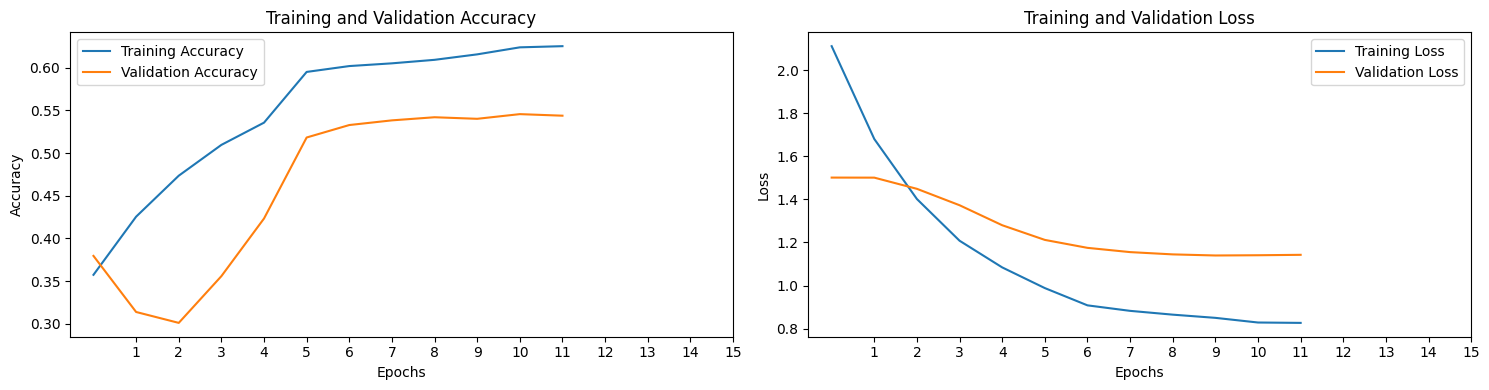

In [41]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xticks(ticks = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xticks(ticks = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

### **Evaluation & Generalization** ###

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


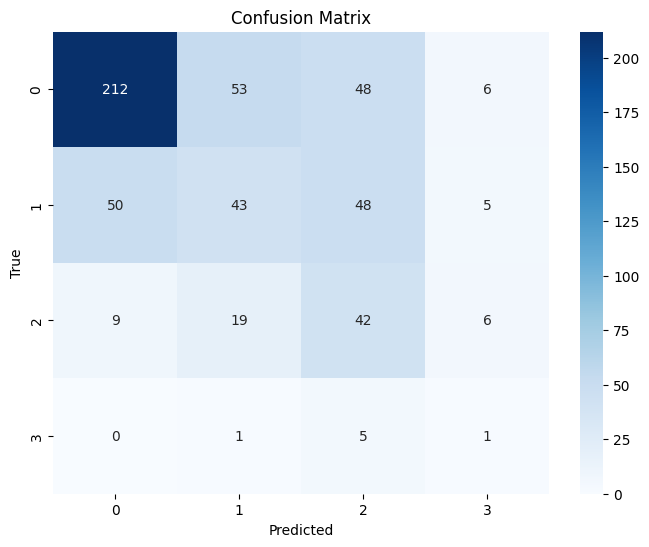

In [42]:
# Calculate confusion matrix of model_tf
#1. get prediction on validation set 
y_pred_prob = model_tf.predict(X_val_enc)
y_pred = np.argmax(y_pred_prob, axis = 1).tolist()

#2. get true class labels of validation set
y_true = y_val.tolist()

#3. calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

#4. plot the confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = [0,1,2,3],yticklabels = [0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [43]:
from sklearn.metrics import cohen_kappa_score
def quadratic_weighted_kappa2(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')
kappa_score2 = quadratic_weighted_kappa2(y_true, y_pred)
print("Quadratic Weighted Kappa2:", kappa_score2)

Quadratic Weighted Kappa2: 0.4147404801796508


In [44]:
accurcy_score = accuracy_score(y_true, y_pred)
accurcy_score

0.5437956204379562

In [45]:
f1 = f1_score(y_true, y_pred, average = None)
f1

array([0.71864407, 0.32824427, 0.38356164, 0.08      ])

In [59]:
print("y_pred:",y_pred)
print("y_true:",y_true)

y_pred: [2 1 0 1 1 2 0 1 1 0 2 0 1 0 2 0 2 1 0 2 0 0 0 0 0 0 1 0 3 1 0 0 0 0 0 1 0
 0 0 2 2 0 2 1 0 0 3 1 1 1 0 2 2 0 0 0 0 1 0 2 0 2 1 2 0 0 0 3 0 0 0 1 2 1
 0 2 2 0 0 2 1 0 0 1 1 0 2 0 2 0 0 1 2 2 0 1 2 0 0 1 2 0 0 2 0 2 0 0 2 0 0
 0 1 2 0 0 0 1 1 0 0 0 2 0 0 0 2 1 2 2 0 0 2 0 0 3 1 0 0 1 1 2 2 0 2 0 2 2
 2 2 2 0 0 2 0 0 3 0 0 2 2 2 0 2 1 0 0 0 0 0 0 2 0 2 1 0 0 0 0 2 1 0 0 0 1
 0 1 1 0 0 0 2 0 0 0 2 1 2 1 0 0 0 1 0 0 0 1 0 1 0 2 2 0 1 0 0 2 1 0 1 2 0
 3 0 2 0 2 0 0 0 1 0 0 2 0 2 1 0 2 0 0 0 1 0 1 1 0 3 0 0 0 0 0 1 1 0 0 0 2
 0 0 0 2 1 2 0 2 0 0 0 0 0 2 0 1 0 2 2 0 1 0 0 2 2 3 0 3 0 1 0 1 0 0 1 0 0
 0 1 2 2 2 0 2 2 1 2 2 2 2 0 0 0 0 2 0 0 0 1 2 0 0 2 1 1 2 2 2 1 2 2 0 2 0
 0 0 1 2 0 0 1 0 3 0 1 1 1 1 0 1 0 2 1 0 0 2 2 0 0 0 0 2 2 0 0 2 0 0 2 3 2
 2 0 1 0 1 0 0 0 0 2 1 1 0 0 0 2 2 0 3 0 2 0 0 0 0 0 0 2 0 0 1 0 2 0 1 2 0
 2 1 1 0 0 2 0 2 0 2 0 0 2 0 0 2 2 0 0 2 1 1 2 0 2 0 2 1 0 2 3 0 0 2 1 0 1
 1 1 0 1 2 0 1 2 3 0 0 0 0 0 2 2 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 2 0
 1 1 2 2 2 1 0 2 

In [60]:
test = to_categorical(y_pred, num_classes = 4)
test

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [53]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=2)
auc = metrics.auc(fpr,tpr)
print("fpr:", fpr)
print("tpr:", tpr)
print("thresholds:",thresholds)
print("auc:", auc)

fpr: [0.         0.02542373 0.23940678 0.44491525 1.        ]
tpr: [0.         0.07894737 0.63157895 0.88157895 1.        ]
thresholds: [4 3 2 1 0]
auc: 0.754725133809099


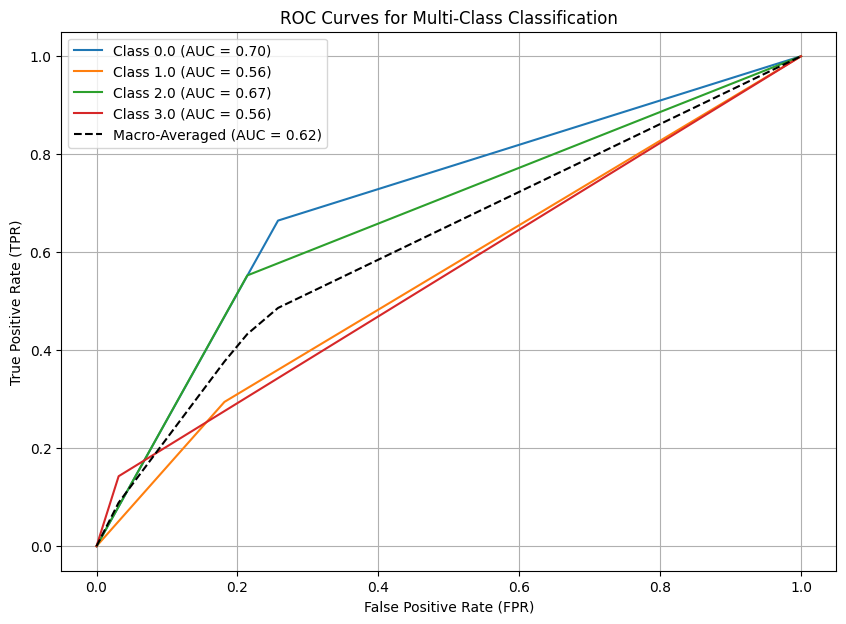

AUC for each class:
Class 0.0: 0.70
Class 1.0: 0.56
Class 2.0: 0.67
Class 3.0: 0.56
Macro-Averaged AUC: 0.62


In [62]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
# Convert y_true and y_pred to NumPy arrays
y_true_v = to_categorical(y_true, num_classes = 4)
y_pred_v = to_categorical(y_pred, num_classes = 4)

# Binarize the true labels
classes = np.unique(y_true)  # Unique class labels
y_true_binarized = label_binarize(y_true, classes=classes)

# Initialize dictionaries to store results
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

# Compute ROC and AUC for each class
for i, class_label in enumerate(classes):
    fpr_dict[class_label], tpr_dict[class_label], thresholds = metrics.roc_curve(
        y_true_binarized[:, i], y_pred_v[:, i]
    )
    roc_auc_dict[class_label] = metrics.auc(fpr_dict[class_label], tpr_dict[class_label])

# Macro-averaged AUC
macro_auc = np.mean(list(roc_auc_dict.values()))

# Plot ROC curves
plt.figure(figsize=(10, 7))
for class_label in classes:
    plt.plot(
        fpr_dict[class_label],
        tpr_dict[class_label],
        label=f"Class {class_label} (AUC = {roc_auc_dict[class_label]:.2f})",
    )

# Add macro-averaged ROC curve
all_fpr = np.unique(np.concatenate([fpr_dict[class_label] for class_label in classes]))
mean_tpr = np.zeros_like(all_fpr)
for class_label in classes:
    mean_tpr += np.interp(all_fpr, fpr_dict[class_label], tpr_dict[class_label])
mean_tpr /= len(classes)

plt.plot(all_fpr, mean_tpr, linestyle="--", color="black", label=f"Macro-Averaged (AUC = {macro_auc:.2f})")

# Add plot details
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for Multi-Class Classification")
plt.legend()
plt.grid()
plt.show()

# Print AUC results
print("AUC for each class:")
for class_label in classes:
    print(f"Class {class_label}: {roc_auc_dict[class_label]:.2f}")
print(f"Macro-Averaged AUC: {macro_auc:.2f}")

In [62]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
n_classes = 4
y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute the macro-average AUC (mean AUC across all classes)
macro_auc = np.mean(list(roc_auc.values()))

# Print results
print("ROC and AUC for each class:")
for i in range(n_classes):
    print(f"Class {i}:")
    print(f"  AUC: {roc_auc[i]:.2f}")

print("\nMacro-Averaged AUC:")
print(f"  Macro AUC: {macro_auc:.2f}")


TypeError: list indices must be integers or slices, not tuple

In [176]:
def quadratic_weighted_kappa(y_true, y_pred, num_classes):
    # Create confusion matrix (O matrix)
    O = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    
    # Create weight matrix W
    W = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            W[i, j] = ((i - j) ** 2) / ((num_classes - 1) ** 2)
    
    # Calculate histograms
    actual_hist = np.sum(O, axis=1)
    pred_hist = np.sum(O, axis=0)
    
    # Create expected matrix E
    E = np.outer(actual_hist, pred_hist) / np.sum(O)
    
    # Calculate kappa
    numerator = np.sum(W * O)
    denominator = np.sum(W * E)
    kappa = 1 - (numerator / denominator)
    
    return kappa

num_classes = 4  
y_true = np.argmax(y_val_v, axis=1)  # Convert one-hot labels to integer class labels
y_pred = np.argmax(model_tf.predict(X_val_enc), axis=1)

kappa_score = quadratic_weighted_kappa(y_true, y_pred, num_classes)
print("Quadratic Weighted Kappa:", kappa_score)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Quadratic Weighted Kappa: 0.41073469900034265


### non_cat_cols**Get test result** ###

In [13]:
# Load ids contained in parquet files name into list_id 
#list_id = []
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
#        if filename.endswith('.parquet'):
 #           string = os.path.join(dirname, filename)
 #           id = string.split('/')[-2].split('=')[-1]
 #           list_id.append(id)
# count number of ids contained in parquet files name            
#num_id = len(set(list_id))
#print(num_id)

# load first paquet file 
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
 #       if filename.endswith('.parquet'):
 #           parquet_file1 = pd.read_parquet(os.path.join(dirname, filename))
 #           break
#parquet_file1.shape

In [ ]:
list_id = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            string = os.path.join(dirname, filename)
            id = string.split('/')[-2].split('=')[-1]
            list_id.append(id)
            
num_id = len(set(list_id))
print(num_id)

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            string = os.path.join(dirname, filename)
            id = string.split('/')[-2].split('=')[-1]
            df_0 = pd.read_parquet(os.path.join(dirname, filename))
            break